In [41]:
import sys
!{sys.executable} -m pip install opencv-python

In [42]:
import cv2
import numpy as np
import math 

# Create the haar cascade
faceCascade = cv2.CascadeClassifier("./data/haarcascade_frontalface_default.xml")

# Read the image
image = cv2.imread("./data/under.jpg", 1)
cv2.imshow("Image",image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [43]:
# Adapted from https://github.com/drakeguan/cp11fall_project1/blob/master/wlsFilter/wlsFilter.m
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
def wls_filter(img_l,alpha=1.2,l=0.5, eps=sys.float_info.epsilon):
    
    img_l = img_l.astype(float)/255.0
    r,c = img_l.shape
    k = r*c;

    # Compute affinities between adjacent pixels based on gradients of L
    dy = np.diff(img_l, 1, 0);
    dy = -l / (np.absolute(dy)**alpha + eps)
    dy = (np.vstack((dy, np.zeros(c, )))).flatten('F')

    dx = np.diff(img_l, 1, 1); 
    dx = -l / (np.absolute(dx)**alpha + eps)
    dx = (np.hstack((dx, np.zeros(r, )[:, np.newaxis]))).flatten('F')


    # Construct a five-point spatially inhomogeneous Laplacian matrix
    B = np.vstack((dx,dy))
    d = [-r,-1]
    A = spdiags(B,d,k,k)

    e = dx
    w = np.roll(dx,r)
    s = dy
    n = np.roll(dy,1)

    D = 1 - (e+w+s+n)

    A = A + A.T + spdiags(D, 0, k, k);

    #Solve
    OUT = spsolve(A, img_l.flatten('F')).reshape(img_l.shape[::-1])
    
    base = np.rollaxis(OUT,1)
    detail = img_l - base
    return (base,detail)

In [44]:
from pySaliencyMap import pySaliencyMap
import matplotlib.pyplot as plt

def shadow_enhance(img):
    # Perform edge-preserving base/detail decomposition
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    (base, detail) = wls_filter(lab[:,:,0])
    
    base *= 255
    detail *=255
    saliency_map = pySaliencyMap(img.shape[1],img.shape[0])
    energy_map = saliency_map.SMGetSM(img)
    plt.imshow(energy_map,cmap="rainbow")
    plt.show()
    l = lab[:,:,0]
    dark = (l<50) & (np.maximum.reduce([img[:,:,0],img[:,:,1],img[:,:,2]]) - np.minimum.reduce([img[:,:,0],img[:,:,1],img[:,:,2]])>5)
    dark_base, dark_detail = wls_filter(l[dark].reshape((-1,1)))
    f_sal = min(2.0,1.0*np.percentile(l[~dark],35)/np.percentile(dark_base,95))
    lab[:,:,0] = ((f_sal*energy_map*base + (1-energy_map)*base)+detail).clip(0,255).astype(int)
    img_out = cv2.cvtColor(lab,cv2.COLOR_Lab2BGR)
    
    return img_out

C:\Users\gbata\AppData\Local\Temp\ipykernel_2596\1888907234.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_lum = img_lum.astype(np.float)/255.0
C:\Users\gbata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


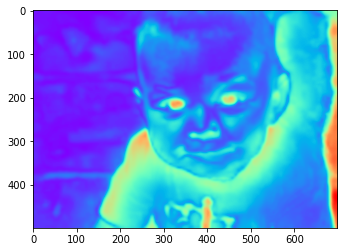

ValueError: k exceeds matrix dimensions

In [45]:
img_out = shadow_enhance(image)

In [ ]:
cv2.imshow("Original",image)
cv2.imshow("Final Result",img_out)
cv2.waitKey(0)
cv2.destroyAllWindows()